Generative and DL techniques on small metabolic engineering datasets

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/carotenoid_production.csv')
df.head(3)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.862946,0.987876,0.892209,0.909210,0.848096,0.840536,0.829163,0.753874,3.739360
1,0.783979,1.001960,0.978865,0.916151,0.718987,0.827099,0.960778,0.770533,2.448719
2,0.870862,0.796111,1.096750,0.919447,0.770546,0.879257,0.956943,0.909107,2.454255


Normalize dataset

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
norm_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
norm_df.head(3)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.027777,0.010061,0.029076,0.012597,0.023213,0.014901,0.090625,0.004667,0.275487
1,0.023719,0.010800,0.032791,0.012933,0.016485,0.014219,0.112340,0.005539,0.138467
2,0.028184,0.000000,0.037845,0.013093,0.019172,0.016867,0.111708,0.012790,0.139054


VAE for generating synthetic data

In [4]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

# Use cuda if available
physical_devices = tensorflow.config.list_physical_devices('GPU')
if physical_devices:
    tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

2024-05-14 18:07:33.813596: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 18:07:33.816114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 18:07:33.851170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 18:07:33.851198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 18:07:33.851221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [6]:
img_size_1 = df.shape[1]
latent_space_dim = 2

# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

# Decoder
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=int(img_size_1*64), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=(img_size_1,1,64))(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decode = tensorflow.keras.layers.Reshape(target_shape=(img_size_1,1,1))
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")


In [7]:
# Loss function
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [8]:
# Combine Encoder-Decoder
vae_input = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 9, 1, 1)]         0         
                                                                 
 encoder_model (Functional)  (None, 2)                 94354     
                                                                 
 decoder_model (Functional)  (None, 9, 1, 1)           113537    
                                                                 
Total params: 207891 (812.07 KB)
Trainable params: 207057 (808.82 KB)
Non-trainable params: 834 (3.26 KB)
_________________________________________________________________


In [9]:
np.array(norm_df).reshape(-1,df.shape[1],1,1).shape

(168, 9, 1, 1)

In [10]:
# Encoder
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [11]:
col_index  = {i:j for i, j in enumerate(norm_df.iloc[0].index.to_list())}

In [12]:
reshaped_array = np.array(norm_df).reshape(-1, 9, 1, 1)
reshaped_array.shape

(168, 9, 1, 1)

In [15]:
history = vae.fit(reshaped_array, reshaped_array, epochs=100, batch_size=10, shuffle=True).history

Epoch 1/100
 7/17 [===========>..................] - ETA: 0s - loss: 17.3381

17/17 [==============================] - 0s 26ms/step - loss: 16.8578
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 14.8760
Epoch 3/100
17/17 [==============================] - 0s 29ms/step - loss: 14.8595
Epoch 4/100
17/17 [==============================] - 0s 28ms/step - loss: 14.9322
Epoch 5/100
17/17 [==============================] - 0s 28ms/step - loss: 14.3057
Epoch 6/100
17/17 [==============================] - 0s 29ms/step - loss: 13.3797
Epoch 7/100
17/17 [==============================] - 0s 28ms/step - loss: 15.4490
Epoch 8/100
17/17 [==============================] - 0s 29ms/step - loss: 15.1919
Epoch 9/100
17/17 [==============================] - 0s 27ms/step - loss: 14.1605
Epoch 10/100
17/17 [==============================] - 0s 28ms/step - loss: 13.8528
Epoch 11/100
17/17 [==============================] - 0s 27ms/step - loss: 14.5146
Epoch 12/100
17/17 [==============================] - 0s 28ms/step - loss: 14.7898
Epoch 13/100
17/17 [=====

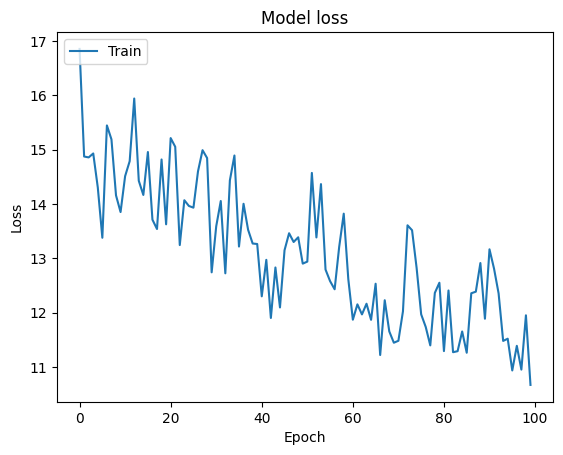

In [16]:
# Plot loss
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Testing

In [17]:
# Passing any random 2 numbers to decoder
z_sample = np.array([[-1, 0.6]])
decoder.predict(z_sample)

1/1 [==============================] - 1s 554ms/step


array([[[[0.11328497]],

        [[0.0886109 ]],

        [[0.11498476]],

        [[0.10492858]],

        [[0.07782274]],

        [[0.17742546]],

        [[0.14063862]],

        [[0.19382584]],

        [[0.47626123]]]], dtype=float32)